In [1]:
!pip install tensorflow numpy opencv-python matplotlib seaborn


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import seaborn as sns

In [14]:
# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    rotation_range=30,             # Random rotations
    width_shift_range=0.2,         # Random shifts
    height_shift_range=0.2,        # Random shifts
    shear_range=0.2,               # Random shear transformations
    zoom_range=0.2,                # Random zooms
    horizontal_flip=True,          # Random horizontal flip
    fill_mode='nearest'            # Padding mode
)

# Define data augmentation for validation/test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale

# Set up the training generator (adjust the paths according to your dataset structure)
train_generator = train_datagen.flow_from_directory(
    '/home/system/Downloads/dataset/train',               # Path to train dataset
    target_size=(128, 128),         # Resize images to 128x128
    batch_size=32,                 # Adjust batch size depending on your system's memory
    class_mode='binary'            # Binary classification (animal vs no-animal)
)

# Set up the validation generator
validation_generator = test_datagen.flow_from_directory(
    '/home/system/Downloads/dataset/val',                 # Path to validation dataset
    target_size=(128, 128),         # Resize images to 128x128
    batch_size=32,                 # Adjust batch size
    class_mode='binary'            # Binary classification (animal vs no-animal)
)


Found 4 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [15]:
# Create a CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to convert 2D data to 1D
model.add(Flatten())

# Fully connected (dense) layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Output layer (1 unit for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100,             # Steps per epoch (adjust as per dataset size)
    epochs=15,                       # Number of epochs (adjust as needed)
    validation_data=validation_generator,
    validation_steps=50             # Validation steps (adjust as per dataset size)
)


Epoch 1/15
100/100 [==============================] - 1s 2ms/step - loss: 0.6955 - accuracy: 0.2500 - val_loss: 0.7991 - val_accuracy: 0.5000


In [17]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")


1/1 [==============================] - 0s 58ms/step - loss: 0.7991 - accuracy: 0.5000
Validation Accuracy: 50.00%
Validation Loss: 0.7991


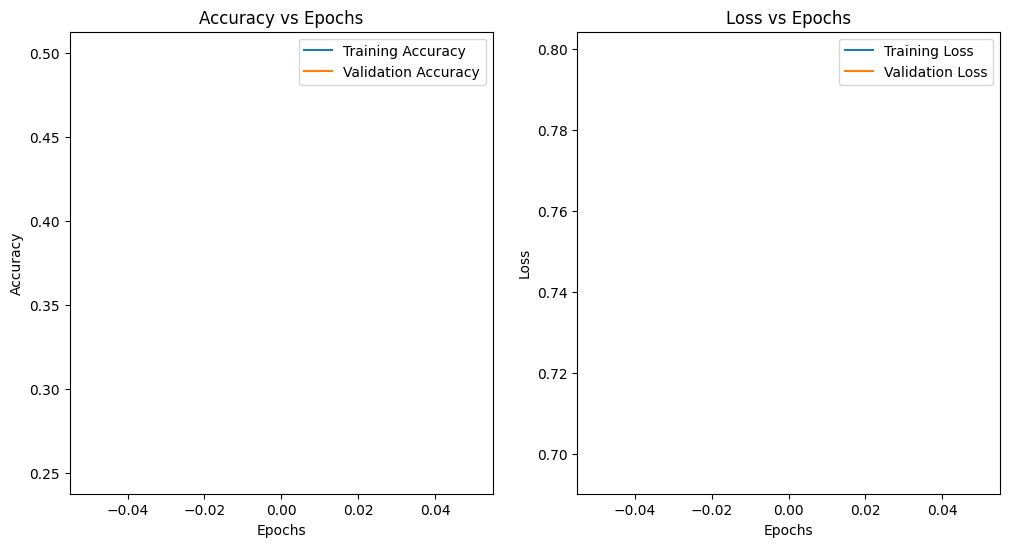

In [18]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [19]:
# Save the trained model
model.save("animal_detector_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [9]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("animal_detector_model.h5")
print("Model loaded successfully!")


Model loaded successfully!


In [21]:
import cv2

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img_resized = cv2.resize(frame, (128, 128)) / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    # Predict using the model
    prediction = model.predict(img_resized)

    label = "Animal Detected" if prediction[0][0] > 0.5 else "No Animal"
    color = (0, 255, 0) if prediction[0][0] > 0.5 else (0, 0, 255)

    # Display the result
    cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.imshow("Animal Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


[ WARN:0@43.245] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@43.245] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make a prediction
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize to match model input
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        print("Animal Detected!")
    else:
        print("No Animal Detected!")

# Test the model on a sample image
predict_image("/home/system/Downloads/car.jpeg", model)


1/1 [==============================] - 0s 94ms/step
No Animal Detected!


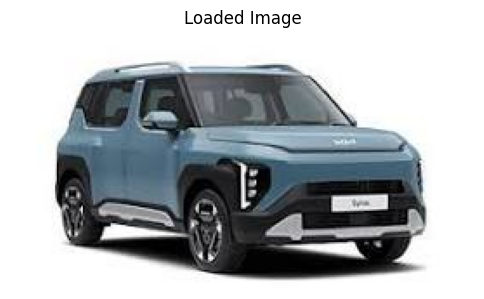

In [23]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = "/home/system/Downloads/car.jpeg"  # Change this to your image path
frame = cv2.imread(image_path)

# Check if the image was loaded successfully
if frame is None:
    print(f"Error: Unable to load image at {image_path}")
else:
    # Convert image from BGR (OpenCV default) to RGB (Matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(6, 6))  # Set figure size
    plt.imshow(frame_rgb)
    plt.axis("off")  # Hide axes
    plt.title("Loaded Image")
    plt.show()
